# Generate a fake POTE input file

The goal is to be able to test CASD script locally.

Objectif : nous voulons des revenus entre 0 et 300 millions avec beaucoup de personnes vers 0 et un petit peut vers le million.

La distribution de Pareto peut nous donner cela.

TODO:
- Actuellement tous les revenus sont indépendants, il faudrait plutôt tout calculer à partir du RFR (avec un random)

In [ ]:
from leximpact_common_python_libraries.config import Configuration

In [ ]:
config = Configuration(project_folder="leximpact-prepare-data")
OUT_PATH = config.get("FAKE_DATA")

In [ ]:
# Activate multi-output in notebook
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# import numpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vaex
import seaborn as sns

In [ ]:
!python --version

Python 3.10.12


## Utilisation de Pareto généralisé
Voir la doc de scipy : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html

mean=array(1.11111111) var=array(1.54320988) skew=array(2.81105689) kurt=array(14.82857143)
x.shape=(100,)


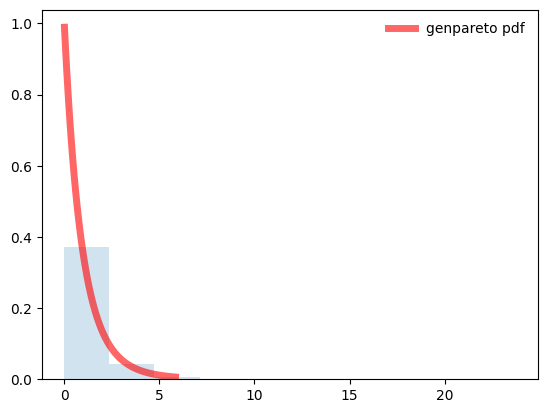

In [ ]:
from scipy.stats import genpareto

c = 0.1

mean, var, skew, kurt = genpareto.stats(c, moments="mvsk")

print(f"{mean=} {var=} {skew=} {kurt=}")

x = np.linspace(genpareto.ppf(0.01, c), genpareto.ppf(0.99, c), 100)
print(f"{x.shape=}")

fig, ax = plt.subplots(1, 1)
_ = ax.plot(x, genpareto.pdf(x, c), "r-", lw=5, alpha=0.6, label="genpareto pdf")

r = genpareto.rvs(c, size=100_000)
_ = ax.hist(r, density=True, histtype="stepfilled", alpha=0.2)
_ = ax.legend(loc="best", frameon=False)
plt.show()

In [ ]:
sorted(r * 10e6)[10:2:-10]

[1092.9815492159842]

## Exemple de distribution

Par exemple, ici on demande :
- Un coefficient c (de Pareto ?) de 0.5, plus il se rapproche de 1, plus la "cassure" entre haut et bas revenus est forte
- size=100 personnes
- scale=100 l'amplitude de revenu : le revenu maximum dépendra de ce paramètre et du coéfficient c. Avec c=0.5 et scale=1 000, le revenu maximum est de 17 000.
- loc=0 le revenu minimum.

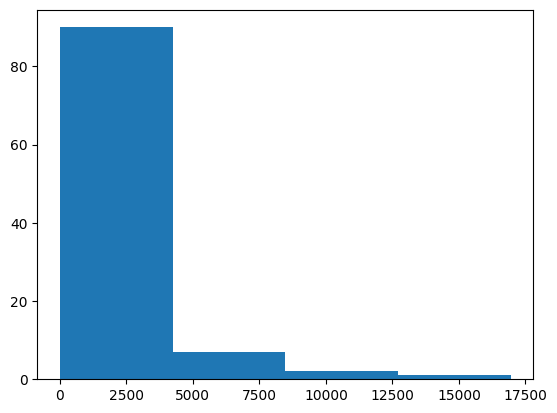

In [ ]:
c = 0.5
r = genpareto.rvs(c, size=100, loc=0, scale=1_000, random_state=1)
count, bins, ax = plt.hist(r, 4, density=False)

In [ ]:
print(f"{r.shape=}  {r.min()=} {r.mean()=} {r.max()=}")
print(f"Frontière de l'histogramme :{bins}")
print(f"Nombre de personnes dans chaque bars :{count}")

r.shape=(100,)  r.min()=0.11438462947924068 r.mean()=1657.342156816486 r.max()=16949.974367913703
Frontière de l'histogramme :[1.14384629e-01 4.23757938e+03 8.47504438e+03 1.27125094e+04
 1.69499744e+04]
Nombre de personnes dans chaque bars :[90.  7.  2.  1.]


On voit sur l'histogramme qu'on a 90% des personnes qui gagnent moins de 4 237 €

Et seulement 1% qui gagnent plus de 12 700 €, avec un maximum de 16 949 €

## Génération d'un grand nombre de données

In [ ]:
def get_random_data(nb_zeros: int, nb_above_zero: int, c=0.9, scale=80_000):
    """
    ::nb_zeros:: Nombre d'individus à 0
    ::nb_above_zero:: Nombre d'individus pour lesquels générer une valeur
    """
    zeros = np.zeros((nb_zeros,))
    # Using numpy.random.pareto() method
    pareto = genpareto.rvs(c, size=nb_above_zero, loc=0, scale=scale, random_state=1)
    return np.concatenate((zeros, pareto), axis=0)

In [ ]:
c = 0.6
r = get_random_data(
    nb_zeros=2_000_000, nb_above_zero=36_000_000, c=c, scale=4000 * (1 / c)
)
print(f"{r.shape=}  {r.min()=} {r.mean()=} {r.max()=}")
df = pd.DataFrame({"revkire": r})

r.shape=(38000000,)  r.min()=0.0 r.mean()=15795.173430857798 r.max()=375678496.8283032


### Calcul des centiles

In [ ]:
nb_quantiles = 100
centile = [(1 / nb_quantiles) * (i + 1) for i in range(nb_quantiles)]
centile[49]

0.5

In [ ]:
quantiles = df.quantile(centile)
df_quantiles = pd.DataFrame(quantiles)
df_quantiles["quantiles"] = df_quantiles.index * 100
df_quantiles["quantiles"] = df_quantiles["quantiles"].astype(int)

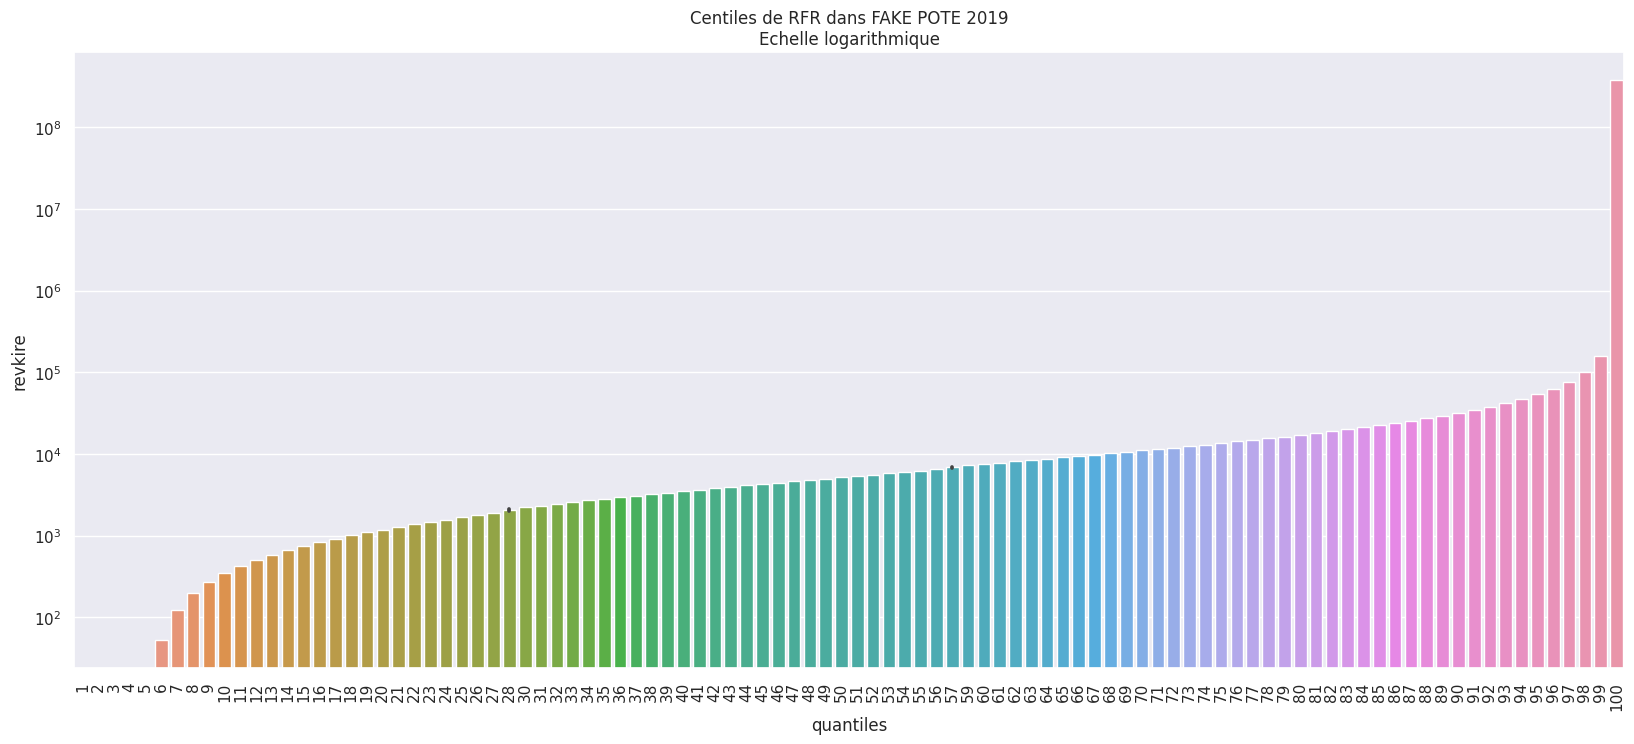

In [ ]:
sns.set(rc={"figure.figsize": (20, 8)})
ax = sns.barplot(data=df_quantiles, x="quantiles", y="revkire")
_ = ax.set_yscale("log")
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
_ = ax.set_title("Centiles de RFR dans FAKE POTE 2019\nEchelle logarithmique")

On est très proche de ce qu'on l'on a vu sur POTE. 👏 

## On le fait pour plusieurs de colonnes

In [ ]:
from random import random

random()

0.44367670147237526

In [ ]:
sas_columns = [
    "rnsgbd",
    "rnsgld",
    "revkire",
    "Z1aj",
    "Z1ap",
    "Z1as",
    "Z1bj",
    "Z1bp",
    "Z1bs",
    "Z1cj",
    "Z1cw",
    "Z1dw",
    "Z2ch",
    "Z2dc",
    "Z2dh",
    "Z2tr",
    "Z3ua",
    "Z3vg",
    "Z3vz",
    "Z4ba",
    "Z4bb",
    "Z4bc",
    "Z4bd",
    "Z4be",
    "Z6de",
    "Z8sc",
    "Z8sw",
    "Z8sx",
    "CICS",
    "MNIMQG",
]
col_to_fake = []
for col in sas_columns:
    c = 0.6 + random() / 5
    col_dict = {
        "name": col,
        "c": c,
        "nb_zeros": int(2_000_000 * random()),
        "scale": 4000 * (1 / c),
    }
    col_to_fake.append(col_dict)
# col_to_fake

In [ ]:
def gen_all_data(reduce_output_ratio=100, filepath=None):
    """
    ::reduce_output_ratio::  1 for full data, 2 for alf.
    ::filepath:: Chemin et nom du fichier à sauver
    """
    df_pote = None
    nb_ff = 39_000_000
    for col in col_to_fake:
        values = get_random_data(
            nb_zeros=col["nb_zeros"] // reduce_output_ratio,
            nb_above_zero=(nb_ff - col["nb_zeros"]) // reduce_output_ratio,
            c=col["c"],
            scale=col["scale"],
        )
        df_temp = vaex.from_dict({col["name"]: values.astype(int)})
        if df_pote is not None:
            df_pote = df_pote.join(df_temp)
        else:
            df_pote = df_temp
    if filepath:
        df_pote.export_parquet(filepath)
    return df_pote

In [ ]:
df_pote = gen_all_data(reduce_output_ratio=10_000)

## On le sauve dans le même format que sur le CASD

Parquet occupe moins d'espace que Arrow. Mais arrow ne nécessite quasiment pas de CPU car le fichier est chargé en mémoire tel quel.

Test avec 39 millions de lignes et 29 colonnes int64 sur notre machine dans DC5:
 - Parquet : 2.7G enregistrés en 22 secondes. (CPU Time = Wall time)
 - Arrow : 4.9G enregistrés en moins de 4 secondes de temps CPU. (mais 44s de Wall time)
 
 => Arrow est donc plus consommateur en espace disque, beaucoup moins en CPU. Mais en temps d'attente perçu c'est équivalent.

In [ ]:
df_pote.export_parquet(f"{OUT_PATH}fake_pote_light.parquet")

In [ ]:
df_pote_full = gen_all_data(reduce_output_ratio=1)

: 

In [ ]:
len(df_pote_full.get_column_names())

29

In [ ]:
len(df_pote_full)

39000000

In [ ]:
%%time
df_pote_full.export_parquet(f"{OUT_PATH}fake_pote_full.parquet")

CPU times: user 22.2 s, sys: 667 ms, total: 22.9 s
Wall time: 22.9 s


In [ ]:
%%time
df_pote_full.export(f"{OUT_PATH}fake_pote_full.arrow")

CPU times: user 482 ms, sys: 3.29 s, total: 3.77 s
Wall time: 44.3 s


In [ ]:
!du -h {OUT_PATH}/*

4.9G	/mnt/data-out/leximpact/fake//fake_pote_full.arrow
2.7G	/mnt/data-out/leximpact/fake//fake_pote_full.parquet
608K	/mnt/data-out/leximpact/fake//fake_pote_light.parquet


In [ ]:
%%time
df_pote_full.describe()

rnsgbd              rnsgld         revkireZ1aj  \
data_type               int64               int64               int64   
count                39000000            39000000            39000000   
NA                          0                   0                   0   
mean       23612.393908666665  16686.731979897435  17999.188046692307   
std             1985728.12425       168367.593804       468129.681965   
min                         0                   0                   0   
max                6365242793           391375749          1309974940   

                        Z1ap               Z1as               Z1bj  \
data_type              int64              int64              int64   
count               39000000           39000000           39000000   
NA                         0                  0                  0   
mean       22921.20886292308  17040.07205202564  17793.07362046154   
std           1757926.167845       348813.11135      407738.350287   
min                        0                  0                  0   
max               5585390554          939653071         1120062522   

                         Z1bp               Z1bs                Z1cj  \
data_type               int64              int64               int64   
count                39000000           39000000            39000000   
NA                          0                  0                   0   
mean       17940.101138589744  22387.16365876923  21754.137213666665   
std             447581.264892     1463643.637909      1409093.278272   
min                         0                  0                   0   
max                1245031261         4582824917          4402079217   

                         Z1cw  ...                Z4bb               Z4bc  \
data_type               int64  ...               int64              int64   
count                39000000  ...            39000000           39000000   
NA                          0  ...                   0                  0   
mean       17330.203434615385  ...  16978.268014820515  16787.83353846154   
std             341201.458036  ...        257858.16848      304306.782644   
min                         0  ...                   0                  0   
max                 913693388  ...           658515059          802706621   

                    Z4bd                Z4be                Z6de  \
data_type          int64               int64               int64   
count           39000000            39000000            39000000   
NA                     0                   0                   0   
mean        19892.917132  18082.292583871797  16897.733525717947   
std        792156.835406       452162.364351       206769.636616   
min                    0                   0                   0   
max           2348740734          1258784526           504485451   

                        Z8sc               Z8sw                Z8sx  \
data_type              int64              int64               int64   
count               39000000           39000000            39000000   
NA                         0                  0                   0   
mean       20601.45104748718  16426.29728551282  16835.938336615385   
std             933589.30553      174934.347089        200883.42422   
min                        0                  0                   0   
max               2811703378          411754892           487116689   

                         CICS              MNIMQG  
data_type               int64               int64  
count                39000000            39000000  
NA                          0                   0  
mean       20841.969054974357  20157.805337358976  
std            1257896.347618       1004222.29896  
min                         0                   0  
max                3897076655          3048988994  

[7 rows x 29 columns]

In [ ]:
# df_pote_sample = df_pote_full.sample(n=300_000)
# df_pote_sample.export_parquet(f"{OUT_PATH}/fake_pote_partial.parquet")

In [ ]:
# df_pote_sample.describe()